<a href="https://colab.research.google.com/github/sidharkal/Image-Denoising-/blob/master/Denoising_Dirty_Documents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!unzip /content/drive/MyDrive/kaggle/denoising-dirty-documents.zip

Archive:  /content/drive/MyDrive/kaggle/denoising-dirty-documents.zip
  inflating: sampleSubmission.csv.zip  
  inflating: test.zip                
  inflating: train.zip               
  inflating: train_cleaned.zip       


# load the necessary library

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import cv2
import keras 
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

# unzip the data from zip file

In [4]:
!unzip /content/test.zip

Archive:  /content/test.zip
   creating: test/
  inflating: test/1.png              
 extracting: test/10.png             
  inflating: test/100.png            
 extracting: test/103.png            
  inflating: test/106.png            
 extracting: test/109.png            
  inflating: test/112.png            
 extracting: test/115.png            
 extracting: test/118.png            
  inflating: test/121.png            
  inflating: test/124.png            
  inflating: test/127.png            
 extracting: test/13.png             
  inflating: test/130.png            
 extracting: test/133.png            
  inflating: test/136.png            
 extracting: test/139.png            
 extracting: test/142.png            
 extracting: test/145.png            
  inflating: test/148.png            
 extracting: test/151.png            
  inflating: test/154.png            
 extracting: test/157.png            
 extracting: test/16.png             
 extracting: test/160.png            
 ex

In [5]:
!unzip /content/train.zip

Archive:  /content/train.zip
   creating: train/
  inflating: train/101.png           
  inflating: train/102.png           
  inflating: train/104.png           
  inflating: train/105.png           
 extracting: train/107.png           
 extracting: train/108.png           
 extracting: train/11.png            
  inflating: train/110.png           
 extracting: train/111.png           
  inflating: train/113.png           
  inflating: train/114.png           
 extracting: train/116.png           
  inflating: train/117.png           
 extracting: train/119.png           
 extracting: train/12.png            
 extracting: train/120.png           
  inflating: train/122.png           
 extracting: train/123.png           
  inflating: train/125.png           
  inflating: train/126.png           
  inflating: train/128.png           
  inflating: train/129.png           
  inflating: train/131.png           
 extracting: train/132.png           
 extracting: train/134.png           
 

In [6]:
!unzip /content/train_cleaned.zip

Archive:  /content/train_cleaned.zip
   creating: train_cleaned/
  inflating: train_cleaned/101.png   
  inflating: train_cleaned/102.png   
  inflating: train_cleaned/104.png   
  inflating: train_cleaned/105.png   
  inflating: train_cleaned/107.png   
  inflating: train_cleaned/108.png   
  inflating: train_cleaned/11.png    
  inflating: train_cleaned/110.png   
  inflating: train_cleaned/111.png   
  inflating: train_cleaned/113.png   
  inflating: train_cleaned/114.png   
  inflating: train_cleaned/116.png   
  inflating: train_cleaned/117.png   
  inflating: train_cleaned/119.png   
  inflating: train_cleaned/12.png    
  inflating: train_cleaned/120.png   
  inflating: train_cleaned/122.png   
  inflating: train_cleaned/123.png   
  inflating: train_cleaned/125.png   
  inflating: train_cleaned/126.png   
  inflating: train_cleaned/128.png   
  inflating: train_cleaned/129.png   
  inflating: train_cleaned/131.png   
  inflating: train_cleaned/132.png   
  inflating: train_clea

In [7]:
!unzip /content/sampleSubmission.csv.zip

Archive:  /content/sampleSubmission.csv.zip
  inflating: sampleSubmission.csv    


In [8]:
train_img = sorted(os.listdir('/content/train'))
train_cleaned_img = sorted(os.listdir('/content/train_cleaned'))
test_img = sorted(os.listdir('/content/test'))

# preprocess data

In [9]:
# prepare function
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (540, 420))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (420, 540, 1))
    
    return img

In [14]:
train = []
train_cleaned = []
test = []

for f in sorted(os.listdir('/content/train/')):
    train.append(process_image( '/content/train/' + f))
   
for f in sorted(os.listdir('/content/test/')):
    test.append(process_image( '/content/test/' + f))

for f in sorted(os.listdir('/content/train_cleaned/')):
    train_cleaned.append(process_image('/content/train_cleaned/' + f))

# Sample Noise and Denoise Images

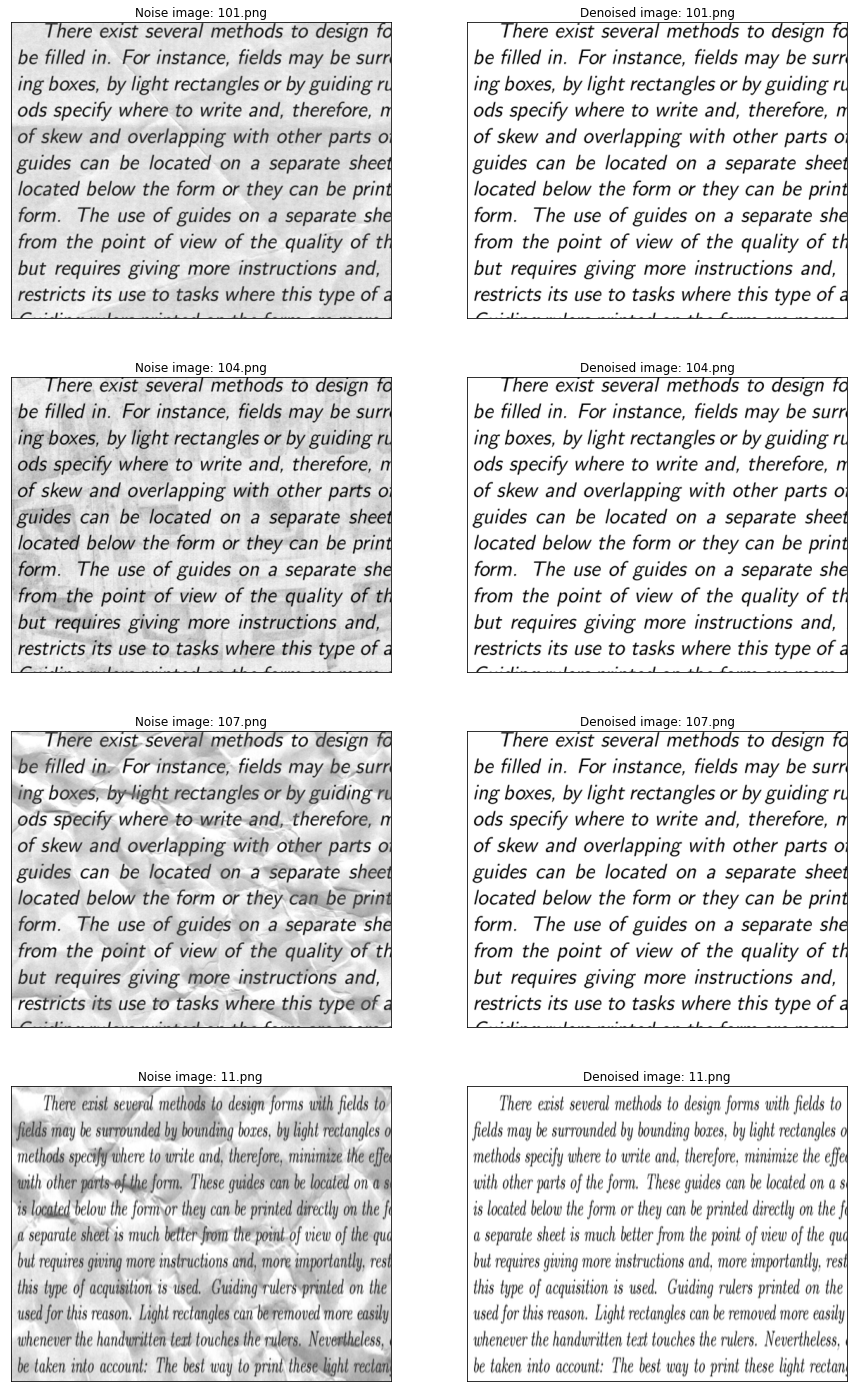

In [15]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][:,:,0], cmap='gray')
    plt.title('Noise image: {}'.format(train_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_cleaned[i][:,:,0], cmap='gray')
    plt.title('Denoised image: {}'.format(train_img[i]))

plt.show()

In [16]:
X_train = np.asarray(train)
Y_train = np.asarray(train_cleaned)
X_test = np.asarray(test)

# Split the data into training and validation

In [17]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)

In [18]:
X_train.shape , X_val.shape

((115, 420, 540, 1), (29, 420, 540, 1))

# Autoencoder Model

In [20]:
def model():
    input_layer = Input(shape=(420, 540, 1))  # we might define (None,None,1) here, but in model summary dims would not be visible
    
    # encoding
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Dropout(0.5)(x)

    # decoding
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)

    output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    model = Model(inputs=[input_layer], outputs=[output_layer])

    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])

    return model


model = model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 420, 540, 1)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 420, 540, 32)      320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 420, 540, 64)      18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 420, 540, 128)     73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 420, 540, 128)     512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 210, 270, 128)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 210, 270, 128)     0   

In [21]:
early_stopping = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=5,
                                       verbose=1, 
                                       mode='auto')

In [23]:
history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=100, batch_size=8, verbose=1, callbacks=[early_stopping])

Epoch 1/100
15/15 [==============================] - 12s 657ms/step - loss: 0.1092 - mae: 0.2671 - val_loss: 0.1813 - val_mae: 0.4141
Epoch 2/100
15/15 [==============================] - 7s 487ms/step - loss: 0.0573 - mae: 0.1841 - val_loss: 0.0943 - val_mae: 0.2875
Epoch 3/100
15/15 [==============================] - 7s 490ms/step - loss: 0.0408 - mae: 0.1464 - val_loss: 0.0724 - val_mae: 0.2280
Epoch 4/100
15/15 [==============================] - 7s 495ms/step - loss: 0.0318 - mae: 0.1246 - val_loss: 0.0687 - val_mae: 0.1973
Epoch 5/100
15/15 [==============================] - 7s 498ms/step - loss: 0.0258 - mae: 0.1105 - val_loss: 0.0682 - val_mae: 0.1786
Epoch 6/100
15/15 [==============================] - 8s 503ms/step - loss: 0.0213 - mae: 0.1008 - val_loss: 0.0692 - val_mae: 0.1614
Epoch 7/100
15/15 [==============================] - 8s 508ms/step - loss: 0.0165 - mae: 0.0920 - val_loss: 0.0701 - val_mae: 0.1517
Epoch 8/100
15/15 [==============================] - 8s 512ms/step -

# loss

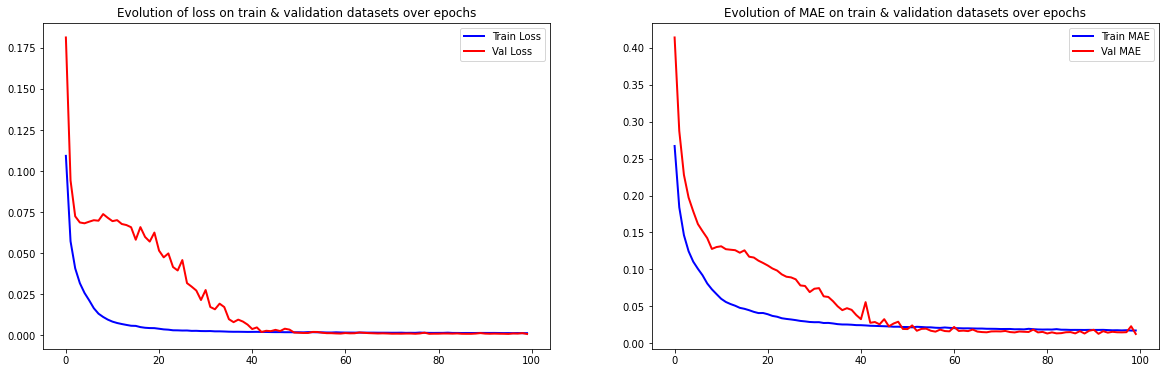

In [24]:
# Check how loss & mae went down
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae = history.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

# Save the Model 

In [25]:
model.save("my_h5_model.h5")

In [30]:
reconstructed_model = keras.models.load_model("my_h5_model.h5")

In [31]:
reconstructed_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 420, 540, 1)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 420, 540, 32)      320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 420, 540, 64)      18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 420, 540, 128)     73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 420, 540, 128)     512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 210, 270, 128)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 210, 270, 128)     0   